In [1]:
import tifffile
import euler_gpu
import os, random
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import matplotlib.pyplot as plt
import numpy as np
import torch
import h5py
from tqdm import tqdm
from math import pi as PI
from math import tau as TAU 
device = torch.device("cuda:0")
BATCH_SIZE = 256
red_channel = 1
fixed_frame = 0

In [2]:
tiff_path = "/storage/fs/store1/brian/swimming_videos_RFa/Folder_20250214153740_RFa/20250214_Experiment_01_0-1999.tif"
# tiff_path = "/storage/fs/store1/brian/swimming_videos_RFa/Folder_20250214153740_RFa/fry_align.tif"

inputs = tifffile.imread(tiff_path)

In [3]:
# inputs = inputs[:, np.newaxis, ...]
# inputs = np.repeat(inputs, 2, 1)

In [3]:
inputs.shape

(2000, 2, 1200, 1200)

In [4]:
TH_CONST = np.array([0])
XY_RANGE_STEP1 = np.concatenate((np.linspace(-0.5, 0.5, 10, dtype=np.float32), TH_CONST)) # Just using this here so we don't have ot redefine
# XY_RANGE_STEP2 = np.concatenate((np.linspace(-0.1, 0.1, 10, dtype=np.float32), TH_CONST)) # Just using this here so we don't have ot redefine
XY_RANGE_STEP2 = np.concatenate((np.linspace(-0.01, 0.01, 10, dtype=np.float32), TH_CONST)) # Just using this here so we don't have ot redefine
# ALIGN_TH_RANGE = np.concatenate((np.linspace(0, .17, 20, dtype=np.float32), np.linspace(3, 3.141592, 20, dtype=np.float32), TH_CONST))
# ALIGN_TH_RANGE = np.concatenate((np.linspace(0, .17, 10, dtype=np.float32), np.linspace(3, 3.141592, 10, dtype=np.float32), TH_CONST))
# ALIGN_TH_RANGE = np.concatenate((np.linspace(0, .04, 5, dtype=np.float32), np.linspace(3.1, 3.141592, 5, dtype=np.float32), TH_CONST))

XY_RANGE_STEP2 = np.concatenate((np.linspace(-0.005, 0.005, 10, dtype=np.float32), TH_CONST)) # Just using this here so we don't have ot redefine
ALIGN_TH_RANGE = np.concatenate((np.linspace(0, 3, 5, dtype=np.float32), np.linspace(357, 60, 5, dtype=np.float32), TH_CONST))

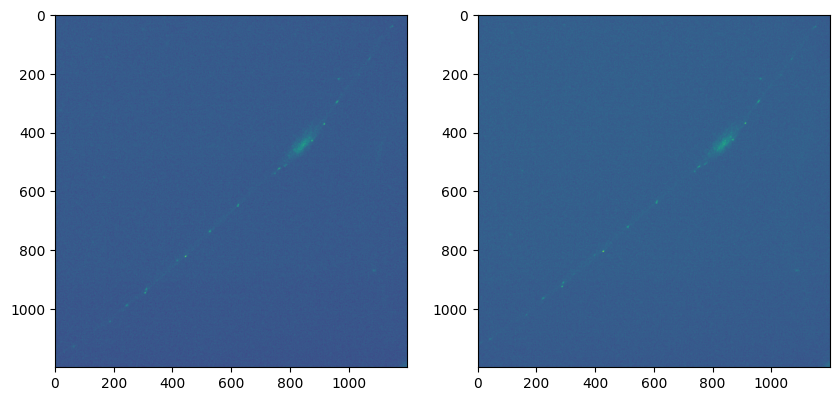

In [5]:
%matplotlib inline
moving_frame = 850

fixed_frame = 298
moving_frame = 299
moving_frame = 415
moving_frame = 340

red = inputs[:, red_channel]
# red = np.sqrt(red - np.min(red))
# red = np.maximum(red, np.median(red))
fixed_image = red[fixed_frame]
moving_image = red[moving_frame]
# fixed_image = fixed_image - np.min(fixed_image)
# moving_image = moving_image - np.min(moving_image)

# fixed_image = fixed_image > np.quantile(fixed_image, 0.7)
# moving_image = moving_image > np.quantile(moving_image, 0.7)

# fixed_image = median(fixed_image, footprint=disk(3))
# moving_image = median(moving_image, footprint=disk(3))
# moving_image = gaussian(moving_image, sigma=2, preserve_range=True)

fig, ax = plt.subplots(1,2, figsize=(10,20))
ax[0].imshow(fixed_image)
ax[1].imshow(moving_image)

In [8]:
memory_dict = euler_gpu.initialize(fixed_image, moving_image, XY_RANGE_STEP1, XY_RANGE_STEP1, TH_CONST, BATCH_SIZE, device)
best_score, best_transformation = euler_gpu.grid_search(memory_dict)
print(best_transformation)
print(best_score)

align_x_range_2 = np.add(XY_RANGE_STEP2, best_transformation[0].cpu().numpy())
align_y_range_2 = np.add(XY_RANGE_STEP2, best_transformation[1].cpu().numpy())
memory_dict = euler_gpu.initialize(fixed_image, moving_image, align_x_range_2, align_y_range_2, ALIGN_TH_RANGE, BATCH_SIZE, device)
best_score, best_transformation = euler_gpu.grid_search(memory_dict)
print(best_transformation)
print(best_score)


(tensor([0.5000], device='cuda:0'), tensor([0.], device='cuda:0'), tensor([0.], device='cuda:0'))
tensor(0.1527, device='cuda:0')
(tensor([0.4967], device='cuda:0'), tensor([0.0056], device='cuda:0'), tensor([0.0262], device='cuda:0'))
tensor(0.1537, device='cuda:0')


In [10]:
best_transformation

(tensor([0.4967], device='cuda:0'),
 tensor([0.0056], device='cuda:0'),
 tensor([0.0262], device='cuda:0'))

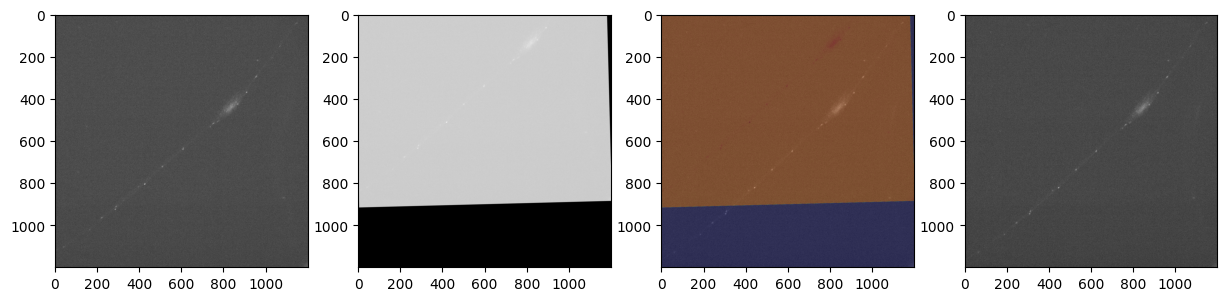

In [9]:
in_img = torch.Tensor(moving_image[np.newaxis, np.newaxis, ...]).to(device=device)
moving_image_transformed = euler_gpu.transform_image(in_img, best_transformation[0], best_transformation[1], best_transformation[2], memory_dict)

fig, ax = plt.subplots(1,4, figsize=(15,30))
ax[0].imshow(moving_image, cmap='gray')
ax[1].imshow(moving_image_transformed.cpu().numpy()[0,0], cmap='gray')
ax[2].imshow(fixed_image, cmap='gray')
ax[2].imshow(moving_image_transformed.cpu().numpy()[0,0], alpha = 0.3, cmap = "jet")
ax[3].imshow(fixed_image, cmap='gray')

In [ ]:
with h5py.File("/home/brian/data4/brian/PBnJ/jelly_h5s/chan-align.h5", 'w') as f:
    f.create_dataset("red", data=fixed_image)
    f.create_dataset("green", data=moving_image)
    f.create_dataset("green_warped", data=moving_image_transformed.cpu().numpy())

tiffout = np.stack([fixed_image, moving_image, moving_image_transformed.cpu().numpy()[0,0]])[:, np.newaxis, ...]
# tiffout = tiffout.astype(np.uint8)
# tifffile.imwrite('/home/brian/data4/brian/PBnJ/jelly_h5s/chan-align.tif', tiffout, photometric='rgb', imagej=True)
tifffile.imwrite('/home/brian/data4/brian/PBnJ/jelly_h5s/chan-align.tif', tiffout, imagej=True)

In [ ]:
np.all(green_image == green_image_transformed.cpu().numpy()[0,0])

False

## Align Entire Video

In [ ]:
out = np.empty_like(inputs)
other_chan = (red_channel - 1) % inputs.shape[1]

for frame in tqdm(range(red.shape[0])):
    moving_image = red[frame]
    memory_dict = euler_gpu.initialize(fixed_image, moving_image, XY_RANGE_STEP1, XY_RANGE_STEP1, TH_CONST, BATCH_SIZE, device)
    best_score, best_transformation = euler_gpu.grid_search(memory_dict)

    align_x_range_2 = np.add(XY_RANGE_STEP2, best_transformation[0].cpu().numpy())
    align_y_range_2 = np.add(XY_RANGE_STEP2, best_transformation[1].cpu().numpy())
    memory_dict = euler_gpu.initialize(fixed_image, moving_image, align_x_range_2, align_y_range_2, ALIGN_TH_RANGE, BATCH_SIZE, device)
    best_score, best_transformation = euler_gpu.grid_search(memory_dict)
    
    in_img = inputs[frame, red_channel]
    in_img = torch.Tensor(in_img[np.newaxis, np.newaxis, ...]).to(device=device)
    out[frame, red_channel] = euler_gpu.transform_image(in_img, best_transformation[0], best_transformation[1], best_transformation[2], memory_dict).cpu().numpy()
    in_img = inputs[frame, other_chan]
    in_img = torch.Tensor(in_img[np.newaxis, np.newaxis, ...]).to(device=device)
    out[frame, other_chan] = euler_gpu.transform_image(in_img, best_transformation[0], best_transformation[1], best_transformation[2], memory_dict).cpu().numpy()



In [ ]:
tifffile.imwrite('/home/brian/data4/brian/PBnJ/jelly_h5s/rig-align-whole.tif', out, imagej=True)


/home/brian/.conda/envs/PB/lib/python3.11/site-packages/tifffile/tifffile.py:3784: UserWarning: <tifffile.TiffWriter 'rig-align.tif'> truncating ImageJ file
  warnings.warn(


## Align Video by adjacent frames

In [ ]:
out = np.empty_like(inputs)
other_chan = (red_channel - 1) % inputs.shape[1]

moving_image = red[0]
memory_dict = euler_gpu.initialize(fixed_image, moving_image, XY_RANGE_STEP1, XY_RANGE_STEP1, ALIGN_TH_RANGE, BATCH_SIZE, device)
best_score, best_transformation = euler_gpu.grid_search(memory_dict)
prev_transform = best_transformation

for frame in tqdm(range(red.shape[0])):
# for frame in range(red.shape[0]):
    moving_image = red[frame]

    align_x_range_2 = np.add(XY_RANGE_STEP2, prev_transform[0].cpu().numpy())
    align_y_range_2 = np.add(XY_RANGE_STEP2, prev_transform[1].cpu().numpy())
    align_the_range = np.add(ALIGN_TH_RANGE, prev_transform[2].cpu().numpy())
    memory_dict = euler_gpu.initialize(fixed_image, moving_image, align_x_range_2, align_y_range_2, align_the_range, BATCH_SIZE, device)
    best_score, best_transformation = euler_gpu.grid_search(memory_dict)
    
    in_img = inputs[frame, red_channel]
    in_img = torch.Tensor(in_img[np.newaxis, np.newaxis, ...]).to(device=device)
    out[frame, red_channel] = euler_gpu.transform_image(in_img, best_transformation[0], best_transformation[1], best_transformation[2], memory_dict).cpu().numpy()
    in_img = inputs[frame, other_chan]
    in_img = torch.Tensor(in_img[np.newaxis, np.newaxis, ...]).to(device=device)
    out[frame, other_chan] = euler_gpu.transform_image(in_img, best_transformation[0], best_transformation[1], best_transformation[2], memory_dict).cpu().numpy()
    # print(best_transformation)

    prev_transform = best_transformation



In [ ]:
tifffile.imwrite('/home/brian/data4/brian/PBnJ/jelly_h5s/rig-align-adj.tif', out, imagej=True)

/home/brian/.conda/envs/PB/lib/python3.11/site-packages/tifffile/tifffile.py:3784: UserWarning: <tifffile.TiffWriter 'rig-align-BOTH.tif'> truncating ImageJ file
  warnings.warn(


## Align Video by adjacent frames over multiple files

In [20]:
# XY_RANGE_STEP2 = np.concatenate((np.linspace(-0.05, 0.05, 10, dtype=np.float32), TH_CONST)) # Just using this here so we don't have ot redefine
# # ALIGN_TH_RANGE = np.concatenate((np.linspace(0, .14, 10, dtype=np.float32), np.linspace(3.0, 3.141592, 10, dtype=np.float32), TH_CONST))
# ALIGN_TH_RANGE = np.concatenate((np.linspace(-.14, .14, 20, dtype=np.float32), TH_CONST))
XY_RANGE_STEP2 = np.concatenate((np.linspace(-0.005, 0.005, 10, dtype=np.float32), TH_CONST)) # Just using this here so we don't have ot redefine
# ALIGN_TH_RANGE = np.concatenate((np.linspace(0, 2, 10, dtype=np.float32), np.linspace(358, 360, 10, dtype=np.float32)))
ALIGN_TH_RANGE = np.concatenate((np.linspace(0, .5, 10, dtype=np.float32), np.linspace(359.5, 360, 10, dtype=np.float32), TH_CONST))

In [ ]:
# XY_RANGE_STEP2 = np.concatenate((np.linspace(-0.01, 0.01, 20, dtype=np.float32), TH_CONST)) # Just using this here so we don't have ot redefine
# ALIGN_TH_RANGE = np.concatenate((np.linspace(0, 1, 20, dtype=np.float32), np.linspace(359, 360, 20, dtype=np.float32), TH_CONST))

In [16]:
ALIGN_TH_RANGE
# XY_RANGE_STEP2

array([0.00000000e+00, 5.26315793e-02, 1.05263159e-01, 1.57894731e-01,
       2.10526317e-01, 2.63157904e-01, 3.15789461e-01, 3.68421048e-01,
       4.21052635e-01, 4.73684222e-01, 5.26315808e-01, 5.78947365e-01,
       6.31578922e-01, 6.84210539e-01, 7.36842096e-01, 7.89473712e-01,
       8.42105269e-01, 8.94736826e-01, 9.47368443e-01, 1.00000000e+00,
       3.59000000e+02, 3.59052643e+02, 3.59105255e+02, 3.59157898e+02,
       3.59210541e+02, 3.59263153e+02, 3.59315796e+02, 3.59368408e+02,
       3.59421051e+02, 3.59473694e+02, 3.59526306e+02, 3.59578949e+02,
       3.59631592e+02, 3.59684204e+02, 3.59736847e+02, 3.59789459e+02,
       3.59842102e+02, 3.59894745e+02, 3.59947357e+02, 3.60000000e+02,
       0.00000000e+00])

In [17]:
tiff_folder = "/storage/fs/store1/brian/swimming_videos_RFa/Folder_20250214153740_RFa"
files = ["20250214_Experiment_01_0-1999.tif", "20250214_Experiment_01_2000-3999.tif", "20250214_Experiment_01_4000-5999.tif"]
# files = ["fry_align.tif"]

# files = ["CHAN_" + f for f in files]
# inputs = tifffile.imread(tiff_path)

In [22]:
import cv2
import numpy as np
from scipy.ndimage import label
import tifffile
import matplotlib.pyplot as plt

def segment_sparse_blobs(
    image,
    blur_sigma=1.5,
    threshold_method="adaptive",  # "adaptive" or "global"
    global_thresh_val=100,
    min_area=20,
    morph_kernel_size=3
):
    """
    Segment sparse blobs in a grayscale image.

    Args:
        image (np.ndarray): Grayscale image.
        blur_sigma (float): Gaussian blur strength.
        threshold_method (str): "adaptive" or "global".
        global_thresh_val (int): Threshold value if using global.
        min_area (int): Minimum area (pixels) to keep a blob.
        morph_kernel_size (int): Size for closing small holes.

    Returns:
        labeled_mask (np.ndarray): Connected component labels.
        centroids (np.ndarray): (x, y) centroid coordinates of blobs.
        contours (list): List of contour arrays.
    """

    # Convert to 8-bit if needed
    if image.dtype != np.uint8:
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Step 1: Smooth image
    blurred = cv2.GaussianBlur(image, (0, 0), blur_sigma)

    # Step 2: Threshold
    if threshold_method == "adaptive":
        binary = cv2.adaptiveThreshold(
            blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY, blockSize=35, C=-10)
    else:
        _, binary = cv2.threshold(blurred, global_thresh_val, 255, cv2.THRESH_BINARY)

    # Step 3: Morphological cleanup
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morph_kernel_size,) * 2)
    cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

    # Step 4: Label connected components
    labeled, num_labels = label(cleaned)

    # Step 5: Filter small blobs and compute centroids
    centroids = []
    contours = []
    output_mask = np.zeros_like(labeled)

    for label_val in range(1, num_labels + 1):
        mask = (labeled == label_val).astype(np.uint8)
        area = np.sum(mask)

        if area >= min_area:
            output_mask[mask > 0] = label_val
            M = cv2.moments(mask)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                centroids.append((cx, cy))
            cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            contours.extend(cnts)

    return output_mask, np.array(centroids), contours


In [18]:
from skimage.filters import median, gaussian
from skimage.morphology import disk

In [ ]:
## Align Video by adjacent frames
# inputs = tifffile.imread(os.path.join(tiff_folder, files[0]))

other_chan = (red_channel - 1) % inputs.shape[1]

# fixed_image = red[0]
# moving_image = red[0]
# # fixed_image = inputs[0, red_channel]
# # moving_image = inputs[0, red_channel]
# memory_dict = euler_gpu.initialize(fixed_image, moving_image, XY_RANGE_STEP1, XY_RANGE_STEP1, ALIGN_TH_RANGE, BATCH_SIZE, device)
# best_score, best_transformation = euler_gpu.grid_search(memory_dict)
# prev_transform = best_transformation

fixed_image = inputs[0, red_channel]
# fixed_image = np.maximum(fixed_image, np.median(fixed_image))
# # fixed_image = median(fixed_image, footprint=disk(3))
# fixed_image = gaussian(fixed_image, sigma=2, preserve_range=True)
# fixed_image = fixed_image > np.quantile(fixed_image, 0.7)
# fixed_image = fixed_image - np.min(fixed_image)
fixed_image = (segment_sparse_blobs(fixed_image)[0] > 0).astype(fixed_image.dtype)

### Testing offset fixed_img
# memory_dict = euler_gpu.initialize(fixed_image, moving_image, XY_RANGE_STEP2, XY_RANGE_STEP2, ALIGN_TH_RANGE, BATCH_SIZE, device)
# in_img = torch.Tensor(fixed_image[np.newaxis, np.newaxis, ...]).to(device=device)
# fixed_image = euler_gpu.transform_image(in_img, torch.tensor([0.01], device='cuda:0'), torch.tensor([0.0], device='cuda:0'), torch.tensor([0.0], device='cuda:0'), memory_dict).cpu().numpy()
# fixed_image = fixed_image[0,0]
# del memory_dict        

prev_transform = (torch.tensor([0.0], device='cuda:0'), torch.tensor([0.0], device='cuda:0'), torch.tensor([0.0], device='cuda:0'))
# prev_transform = (torch.tensor([0.0244], device='cuda:0'), torch.tensor([-0.0378], device='cuda:0'), torch.tensor([0.0007], device='cuda:0'))

for file in files:
    if file == files[0]:
        ins = inputs
    else:
        ins = tifffile.imread(os.path.join(tiff_folder, file))
    # ins = tifffile.imread(os.path.join(tiff_folder, file))
    # ins = ins[:, np.newaxis, ...]
    # ins = np.repeat(ins, 2, 1)

    out = np.empty_like(ins)
    for frame in tqdm(range(ins.shape[0])):
        if frame < 250 or frame > 400:
            continue
    # for frame in range(red.shape[0]):
        moving_image = ins[frame, red_channel]

        ## Image Modifications before Alignment (make sure match fixed image)
        # moving_image = np.maximum(moving_image, np.median(moving_image))
        # moving_image = median(moving_image, footprint=disk(3))
        # moving_image = gaussian(moving_image, sigma=2, preserve_range=True)
        # moving_image = moving_image - np.min(moving_image)
        # moving_image = moving_image > np.quantile(moving_image, 0.7)
        # moving_image = median(moving_image, footprint=disk(3))
        moving_image = (segment_sparse_blobs(moving_image)[0] > 0).astype(moving_image.dtype)
        


        align_x_range_2 = np.add(XY_RANGE_STEP2, prev_transform[0].cpu().numpy())
        align_y_range_2 = np.add(XY_RANGE_STEP2, prev_transform[1].cpu().numpy())
        # align_the_range = np.add(ALIGN_TH_RANGE, prev_transform[2].cpu().numpy())
        align_the_range = np.mod(np.add(ALIGN_TH_RANGE, (prev_transform[2].cpu().numpy() * 180) / PI), 360)
        memory_dict = euler_gpu.initialize(fixed_image, moving_image, align_x_range_2, align_y_range_2, align_the_range, BATCH_SIZE, device)
        best_score, best_transformation = euler_gpu.grid_search(memory_dict)
        
        in_img = ins[frame, red_channel]
        in_img = torch.Tensor(in_img[np.newaxis, np.newaxis, ...]).to(device=device)
        out[frame, red_channel] = euler_gpu.transform_image(in_img, best_transformation[0], best_transformation[1], best_transformation[2], memory_dict).cpu().numpy()
        in_img = ins[frame, other_chan]
        in_img = torch.Tensor(in_img[np.newaxis, np.newaxis, ...]).to(device=device)
        out[frame, other_chan] = euler_gpu.transform_image(in_img, best_transformation[0], best_transformation[1], best_transformation[2], memory_dict).cpu().numpy()
        # print(best_transformation)

        prev_transform = best_transformation
    print(prev_transform)
    tifffile.imwrite(os.path.join(tiff_folder, "RIG_" + file), out[:400], imagej=True)
    # tifffile.imwrite(os.path.join(tiff_folder, "RIG_" + file), out, imagej=True)
    break



TypeError: '_typedict' object is not callable

In [14]:
tifffile.imwrite(os.path.join(tiff_folder, "RIG_" + file), out[:400], imagej=True)
# tifffile.imwrite(os.path.join(tiff_folder, "RIG_" + file), out, imagej=True)